In [1]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
import json
import torchvision.transforms.functional as F
from matplotlib import cm as CM
from image import *
from model import CSRNet
import torch
%matplotlib inline

/tmp/ipykernel_31956/1028975186.py:8: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [2]:
from torchvision import datasets, transforms
transform=transforms.Compose([
                       transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
                   ])

In [3]:
root = ''

In [4]:
#now generate the ShanghaiA's ground truth
part_A_train = os.path.join(root,'part_A_final/train_data','images')
part_A_test = os.path.join(root,'part_A_final/test_data','images')
part_B_train = os.path.join(root,'part_B_final/train_data','images')
part_B_test = os.path.join(root,'part_B_final/test_data','images')
path_sets = [part_A_test]

In [5]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [6]:
model = CSRNet()

/home/datascience/conda/pytorch21_p39_gpu_v1/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/datascience/conda/pytorch21_p39_gpu_v1/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
model = model.cuda()

In [8]:
checkpoint = torch.load('0model_best.pth.tar')

In [9]:
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [12]:
mae = 0
for i in range(len(img_paths)):
    img = 255.0 * F.to_tensor(Image.open(img_paths[i]).convert('RGB'))

    img[0,:,:]=img[0,:,:]-92.8207477031
    img[1,:,:]=img[1,:,:]-95.2757037428
    img[2,:,:]=img[2,:,:]-104.877445883
    img = img.cuda()
    #img = transform(Image.open(img_paths[i]).convert('RGB')).cuda()
    gt_file = h5py.File(img_paths[i].replace('.jpg','.h5').replace('images','ground_truth'),'r')
    groundtruth = np.asarray(gt_file['density'])
    output = model(img.unsqueeze(0))
    mae += abs(output.detach().cpu().sum().numpy()-np.sum(groundtruth))
    print (i,mae)
print (mae/len(img_paths))

0 809.1570434570312
1 872.5372619628906
2 1977.6463928222656
3 19255.839752197266
4 21532.67837524414
5 24601.50454711914
6 26763.44253540039
7 29194.01284790039
8 29675.375518798828
9 31332.692291259766
10 34419.005279541016
11 36097.3215637207
12 38565.62600708008
13 40436.28787231445
14 48305.9016418457
15 51301.28201293945
16 55190.97830200195
17 60837.85427856445
18 63919.64309692383
19 64475.76565551758
20 64514.821868896484
21 65071.398345947266
22 68488.55361938477
23 74466.17715454102
24 76313.9885559082
25 81075.17849731445
26 83561.6731262207
27 93588.4172668457
28 98631.8547668457
29 98730.76092529297
30 100513.1245727539
31 101436.63439941406
32 108350.21936035156
33 109786.11352539062
34 112388.08129882812
35 113754.32019042969
36 122061.76745605469
37 122746.10125732422
38 122986.76922607422
39 124803.99237060547
40 130360.03240966797
41 141375.72186279297
42 144033.28826904297
43 145380.92791748047
44 151172.57147216797
45 158031.99334716797
46 161512.09588623047
47 164

Predicted Count :  1288


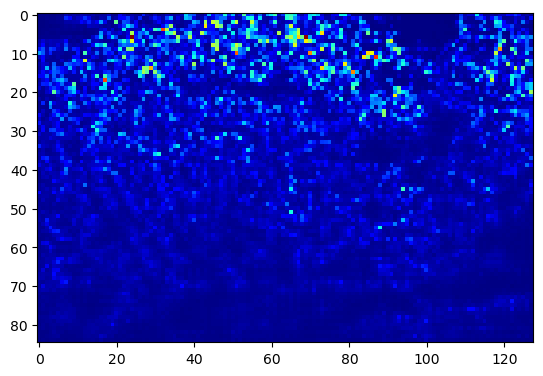

Original Count :  1164


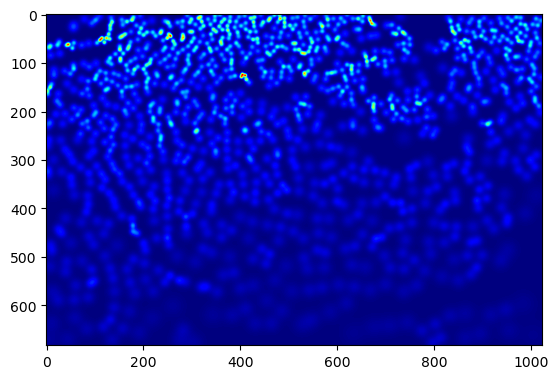

Original Image


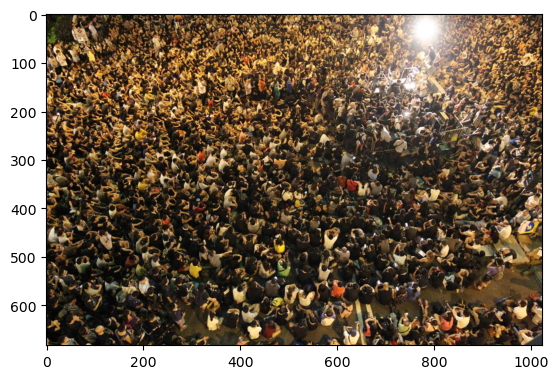

In [22]:
from matplotlib import cm as c
img = transform(Image.open('part_A_final/test_data/images/IMG_104.jpg').convert('RGB')).cuda()

output = model(img.unsqueeze(0))
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()
temp = h5py.File('part_A_final/test_data/ground_truth/IMG_104.h5', 'r')
temp_1 = np.asarray(temp['density'])
plt.imshow(temp_1,cmap = c.jet)
print("Original Count : ",int(np.sum(temp_1)) + 1)
plt.show()
print("Original Image")
plt.imshow(plt.imread('part_A_final/test_data/images/IMG_104.jpg'))
plt.show()